In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import os
import operator
from collections import Counter
from CitNet import Utils, GraphCN
from jyquickhelper import add_notebook_menu

In [2]:
add_notebook_menu()

# Descriptive statistics

In [3]:
# Set path to tables
path = os.path.join(os.getcwd(), "Tables")
path_fig = os.path.join(os.getcwd(), "Figures")

In [4]:
# Load data
attrs=pd.read_csv(path + "/attrs_nos.csv", encoding="ISO-8859-1", index_col=0)
auth_coresp = pd.read_csv(path + "/authors.csv", encoding = "ISO-8859-1")
citations_db=pd.concat([pd.read_csv(path + "/cits_edges.csv"),pd.read_csv(path + "/refs_edges.csv")])

In [5]:
# Variables, parameters, preprocessig
# Series of Authors ID (potentially multiple authors [id_a1, id_a2], dtype:int)
auths_nos=attrs.authors_nos.copy()
auths_nos=auths_nos.apply(Utils.str_to_list)

# Array of quantiles of interest
ptile = np.concatenate([np.linspace(10, 90, 9, dtype=int),np.linspace(91, 99, 9, dtype=int)])
width = np.concatenate([np.ones(9, dtype=int)*.8, np.ones(9, dtype=int)*.4])

In [6]:
# Citations processing 
# Agregate numbe of cits/refs by article
Citations=Counter(citations_db.referred_to)
References=Counter(citations_db.referring)
# Dataframe (! index)
cit_df = pd.DataFrame(data=list(Citations.values()), index=Citations.keys(), columns=["in"])
ref_df = pd.DataFrame(data=list(References.values()), index=References.keys(), columns=["out"])
# Add var to attrs
attrs_df=attrs.merge(cit_df, how='outer', left_index=True, right_index=True)
attrs_df=attrs_df.merge(ref_df, how='outer', left_index=True, right_index=True)
# Fill na
attrs_df["in"]=attrs_df["in"].fillna(0).astype(int)
attrs_df["out"]=attrs_df["out"].fillna(0).astype(int)

In [7]:
# Year Processing
attrs_df["year"]=attrs_df.date.str.split("-").str[0].astype(int)

In [8]:
# Functions
def draw_qdist(counter, quantile):
    """
    :param counter: (Counter) Counter of an object
    :param quantile: (np.ndarray) sequence of quantiles
    :return: (plt.bar) x=quantile
                       y=percentile(counter.values(),q)
    """
    if isinstance(counter, Counter) and isinstance(quantile, np.ndarray) is False:
        print("counter is {0}, only Counter accepted \n quantile is {1}, only np.ndarray accepted".\
             format(type(counter),type(quantile)))
        
    else:
        x = np.percentile(list(counter.values()),quantile)
        plt.bar(np.arange(len(x)), x, width=width)
        plt.xticks(np.arange(len(x)), quantile, rotation='vertical')
        plt.annotate('min={0}'.format(min(counter.values())), xy=(0.05, 0.95), xycoords='axes fraction')
        plt.annotate('max={0}'.format(max(counter.values())), xy=(0.05, 0.90), xycoords='axes fraction');

### Authors

In [9]:
# Number of published articles by author
pubA_list = []
for pubA in auths_nos:  
        pubA_list += pubA
pubA_list.sort()
pub_A = Counter(pubA_list)

In [10]:
# Name instead of id number
pub_Aname={auth_coresp.uniformat.loc[k]:v for k,v in pub_A.items()}

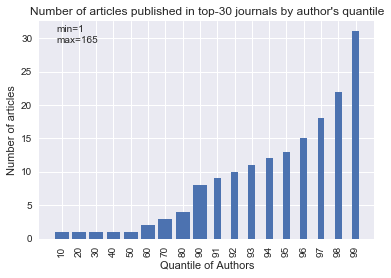

In [11]:
# Plot distribution of Articles by Authors' quantile
draw_qdist(pub_A, ptile)
plt.title("Number of articles published in top-30 journals by author's quantile")
plt.xlabel("Quantile of Authors")
plt.ylabel("Number of articles")
plt.savefig(path_fig + "/q_auth-art.pdf");

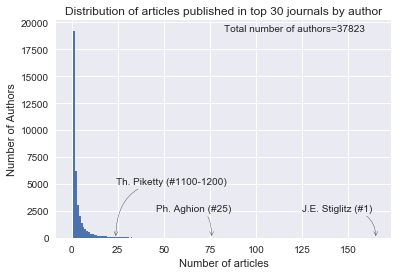

In [12]:
# Hist of publications per author
plt.hist(list(pub_A.values()), bins=np.arange(max(pub_A.values())+1))
plt.annotate('Total number of authors={0}'.format(len(pub_A)),
             xy=(0.5, 0.95), xycoords='axes fraction')
plt.annotate('J.E. Stiglitz (#1)', xy=(165, 0), xytext=(125, 2500),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Ph. Aghion (#25)', xy=(76, 0), xytext=(46, 2500),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Th. Piketty (#1100-1200)', xy=(24, 0), xytext=(24, 5000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.xlabel("Number of articles")
plt.ylabel("Number of Authors")
plt.title("Distribution of articles published in top 30 journals by author")
plt.savefig(path_fig + "/dist_art-auth.pdf");

In [13]:
# Top Authors by number of articles published
tsh = 75 # Choose threshold
x=sorted({k: v for k, v in pub_Aname.items() if v >= tsh}.items(), key=operator.itemgetter(1), reverse=True)
pd.DataFrame(x, columns=["Authors","Articles"])

,Authors,Articles
0,Joseph E Stiglitz,165
1,Martin Feldstein,134
2,R. Gordon,128
3,Daron Acemoglu,124
4,Andrei Shleifer,123
5,James Heckman,113
6,Peter C. B. Phillips,109
7,Jean Tirole,105
8,John J. Siegfried,100
9,P. A. Samuelson,98


In [14]:
def search_auth(auth_name):
    resp_auth=auth_coresp.index[auth_coresp.equivalent.str.contains(auth_name)]
    for i in resp_auth:
        print(auth_coresp.uniformat[i],pub_A[i])

In [15]:
search_auth("Krugman")

Paul Krugman 55


### Co-authors

In [16]:
# Get list of edges
edges_list = GraphCN.get_edges_list(auths_nos)
# Sort list of edges
s_edges_list = GraphCN.sort_edges(edges_list)
s_edges_list = list(map(lambda x: tuple(auth_coresp.uniformat.loc[[x[0], x[1]]].values),s_edges_list))
# Count
C_CoA = Counter(s_edges_list)

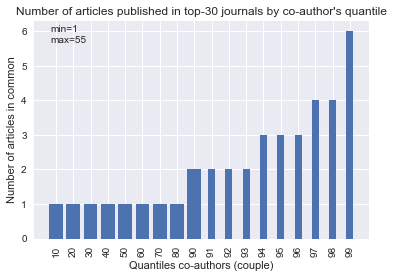

In [17]:
draw_qdist(counter=C_CoA,quantile=ptile)
plt.xlabel("Quantiles co-authors (couple)")
plt.ylabel("Number of articles in common")
plt.title("Number of articles published in top-30 journals by co-author's quantile")
plt.savefig(path_fig + "/q_coa-art.pdf");


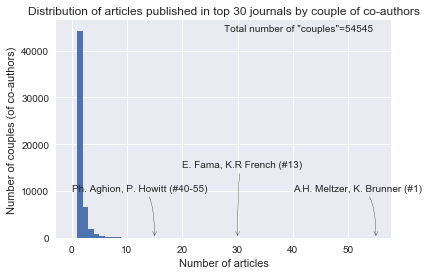

In [18]:
# Hist of publications per author
plt.hist(list(C_CoA.values()), bins=np.arange(max(C_CoA.values())+1))
plt.annotate('Total number of "couples"={0}'.format(len(C_CoA)),
             xy=(0.5, 0.95), xycoords='axes fraction')
plt.annotate('A.H. Meltzer, K. Brunner (#1)', xy=(55, 0), xytext=(40, 10000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('E. Fama, K.R French (#13)', xy=(30, 0), xytext=(20, 15000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Ph. Aghion, P. Howitt (#40-55)', xy=(15, 0), xytext=(0, 10000),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.xlabel("Number of articles")
plt.ylabel("Number of couples (of co-authors)")
plt.title("Distribution of articles published in top 30 journals by couple of co-authors")
plt.savefig(path_fig + "/dist_art-coa.pdf");

In [19]:
# Bromance - Top couples
pd.DataFrame(list({k: v for k, v in C_CoA.items() if v>=15}.items()), 
             columns=["Co-Authors","NbCo"]).sort_values("NbCo", ascending=False)
# Comment: missing trouples

,Co-Authors,NbCo
5,"(Allan H. Meltzer, K. Brunner)",55
18,"(Clifford JR. Smith, Michael C. Jensen)",48
17,"(Clifford JR. Smith, John Jr Long)",48
44,"(John Jr Long, Michael C. Jensen)",47
8,"(Andrei Shleifer, Robert Vishny)",47
33,"(G. William Schwert, Michael C. Jensen)",38
27,"(Edwin J. Elton, Martin Gruber)",37
16,"(Clifford JR. Smith, Jerold B. Warner)",36
42,"(Jerold B. Warner, Michael C. Jensen)",36
15,"(Clifford JR. Smith, G. William Schwert)",36


### Citations

In [20]:
print("There are {0} citations.".format(attrs_df["in"].sum()))
print("On the {0} articles in our dataset, {1} are cited at least once.".\
      format(len(attrs_df), len(attrs_df["in"][(attrs_df["in"]>0)])))
print("On the {0} articles in our dataset, {1} point to at least one article.".\
      format(len(attrs_df), len(attrs_df["out"][(attrs_df["out"]>0)])))

There are 462445 citations.
On the 82206 articles in our dataset, 45068 are cited at least once.
On the 82206 articles in our dataset, 32888 point to at least one article.


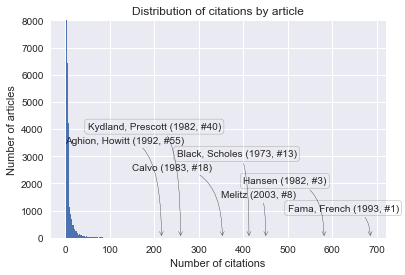

In [21]:
plt.hist(x=attrs_df["in"], bins=np.arange(1,max(attrs_df["in"]+1)))
plt.annotate('Fama, French (1993, #1)', xy=(686, 0), xytext=(500, 1000),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Hansen (1982, #3)', xy=(582, 0), xytext=(400, 2000),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Melitz (2003, #8)', xy=(451, 0), xytext=(350, 1500),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Black, Scholes (1973, #13)', xy=(413, 0), xytext=(250, 3000),
             bbox=dict(boxstyle="round", fc="none", ec="gray"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Calvo (1983, #18)', xy=(353, 0), xytext=(150, 2500),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Kydland, Prescott (1982, #40)', xy=(259, 0), xytext=(50, 4000),
            bbox=dict(boxstyle="round", fc="none", ec="gray"), 
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.annotate('Aghion, Howitt (1992, #55)', xy=(216, 0), xytext=(0, 3500),
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"))
plt.ylim((0,8000))
plt.xlabel("Number of citations")
plt.ylabel("Number of articles")
plt.title("Distribution of citations by article")
plt.savefig(path_fig + "/dist_cit-art.pdf");

In [22]:
# Top cited articles (list by order of citations)
attrs_df[["title","authors","year","in"]].sort_values(by="in", ascending=False).\
to_csv("../Old/topart.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../Old/topart.csv'

#### Time structure of citations

In [ ]:
# Time distribution of most cited papers
trsh=50
x = {k:v for k,v in Citations.items() if v > trsh}
plt.hist(attrs_df.year.loc[x.keys()], bins=np.arange(1880,2020))
plt.annotate('{0} articles'.format(len(x)), xy=(0.05, 0.95), xycoords='axes fraction')
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Time-distribution of articles with more than {0} citations".format(trsh))
plt.savefig(path_fig + "/dist_yr-art.pdf");

In [ ]:
# Time distribution of citations
plt.plot(attrs_df.groupby(["year"]).sum()["in"])
plt.xlim([1880,2018])
plt.xlabel("Year")
plt.ylabel("Number of citations")
plt.title("Time distribution of citations received")
plt.savefig(path_fig + "/dist_yr-cit.pdf");

In [ ]:
# Time distribution of papers in the dataset
plt.hist(attrs_df.year, bins=np.arange(1880,2020))
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Time distribution of articles")
plt.savefig(path_fig + "/dist_yr-art.pdf");

### Journals

In [ ]:
x=attrs_df.groupby(["journal"]).sum().sort_values(by="in")["in"]
plt.bar(np.arange(len(x.values)), x.values)
plt.xticks(np.arange(len(x.values)), x.keys(), rotation='vertical')
plt.title("Sum of citations per journal over time")
plt.savefig(path_fig + "/dist_cit-journ.pdf");